In [8]:
from secret_keys import langsmith_key
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = langsmith_key
os.environ["LANGSMITH_TRACKING"]= "true"

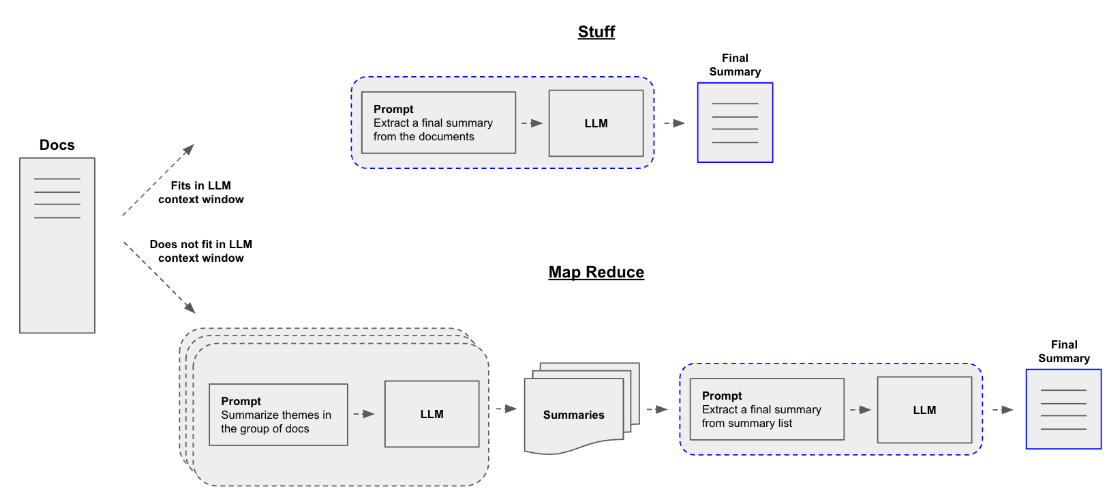

In [5]:
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4 langchain-community

In [42]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [23]:
pip install -qU "langchain[groq]"

In [24]:
from secret_keys import groq_key
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = groq_key
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

### **Stuff: summarize in a single LLM call**

In [36]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain

# Initialize the LLM
llm = init_chat_model("llama3-8b-8192", model_provider="groq")

# Create a text splitter for chunking documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200
)

# Split your documents
split_docs = text_splitter.split_documents(docs)

# Create a map-reduce summarization chain
map_prompt = ChatPromptTemplate.from_template(
    "Summarize the following document:\n\n{text}"
)

reduce_prompt = ChatPromptTemplate.from_template(
    "Combine these summaries into a final summary:\n\n{text}"
)

# Load the summarize chain with map-reduce approach
summarize_chain = load_summarize_chain(
    llm=llm,
    chain_type="map_reduce",
    map_prompt=map_prompt,
    combine_prompt=reduce_prompt,
    verbose=True
)

# Run the chain
result = summarize_chain.invoke(split_docs)
print(result["output_text"])



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Human: Summarize the following document:

LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 

## **Map-Reduce: summarize long texts via parallelization**

### **Map**

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system","Write a concise summary of the following:\\n\\n{context}")]
)
# We can also use the Prompt Hub to store and fetch prompts.
'''
map_prompt = hub.pull("rlm/map-prompt")
'''

### **Reduce**

In [41]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main document.
"""
reduce_prompt = ChatPromptTemplate([("human",reduce_template)])


### **Orchestration via LangGraph**

In [43]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 1000, chunk_overlap = 0
)

split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")


Generated 14 documents.


In [55]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

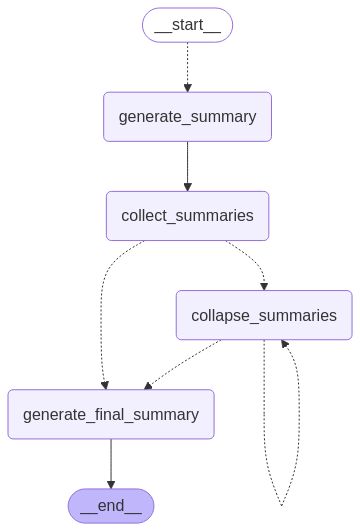

In [56]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [57]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [58]:
print(step)

{'generate_final_summary': {'final_summary': 'Here is a consolidated summary of the main document:\n\nThe document discusses the development of autonomous agents using Large Language Models (LLMs) as their core controller. The agent system consists of three main components: Planning, Memory, and Tool Use. Planning involves breaking down complex tasks into smaller subgoals and refining past actions through self-reflection, with approaches including Task Decomposition and LLM+P. Memory enables the agent to learn and recall information over time, with approaches including short-term and long-term memory capabilities and the use of external information sources. Tool Use allows the agent to access external information sources, such as APIs, to supplement its knowledge.\n\nThe document highlights the importance of self-reflection in autonomous agents, presenting two approaches: ReAct and Reflexion. ReAct integrates reasoning and acting within LLM by extending the action space to include lang